<a href="https://colab.research.google.com/github/srishti1837/ECG-Arrhythmia-Classification-using-Bidirectional-LSTM/blob/main/ECG_Arrhythmia_Classification_using_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECG Arrhythmia Classification using Bidirectional LSTM**
> **95.71% Accuracy in classifying ECG heartbeats into Normal, Supraventricular, Ventricular, Fusion, or Unknown classes using a Bidirectional LSTM with Class-Weighted Loss.**




# **Importing Dataset**

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model
import os
import wfdb
from imblearn.over_sampling import RandomOverSampler

In [ ]:
path = kagglehub.dataset_download("shayanfazeli/heartbeat")
print("Dataset Path:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Dataset Path: /kaggle/input/heartbeat


In [ ]:
train_path = os.path.join(path, "mitbih_train.csv")
test_path  = os.path.join(path, "mitbih_test.csv")

train = pd.read_csv(train_path, header=None)
test  = pd.read_csv(test_path, header=None)

print(train.shape, test.shape)

(87554, 188) (21892, 188)


In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Preparing Data**

In [ ]:
X_train_2D = train.iloc[:, :-1].values
y_train_labels = train.iloc[:, -1].values

X_test_2D = test.iloc[:, :-1].values
y_test_labels = test.iloc[:, -1].values

print("Unique classes:", np.unique(y_train_labels))

Unique classes: [0. 1. 2. 3. 4.]


In [ ]:
class_counts = pd.Series(y_train_labels).value_counts().sort_index()
print("\nClass Distribution in Training Set:")
print(class_counts)


Class Distribution in Training Set:
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64


In [ ]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(weights))

# **Normalizing and Reshaping the Data**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)

print("Scaled (2D) Train Shape:", X_train_scaled.shape)
print("Scaled (2D) Test Shape:", X_test_scaled.shape)

Scaled (2D) Train Shape: (87554, 187)
Scaled (2D) Test Shape: (21892, 187)


In [ ]:
target_size = 35000
sampling_strategy = {
    0: 72471,
    1: target_size,
    2: target_size,
    3: target_size,
    4: target_size
}

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled_labels = ros.fit_resample(X_train_scaled, y_train_labels)
print(f"Resampled Train Shape: {X_train_resampled.shape}")
print("Resampled Class Distribution:\n", pd.Series(y_train_resampled_labels).value_counts().sort_index())


Resampled Train Shape: (212471, 187)
Resampled Class Distribution:
 0.0    72471
1.0    35000
2.0    35000
3.0    35000
4.0    35000
Name: count, dtype: int64


In [ ]:
X_train_final = X_train_resampled.reshape(X_train_resampled.shape[0], 187, 1)
X_test_final = X_test_scaled.reshape(X_test_scaled.shape[0], 187, 1)

print(f"\nFinal Input Shapes (3D): X_train {X_train_final.shape}, X_test {X_test_final.shape}")


Final Input Shapes (3D): X_train (212471, 187, 1), X_test (21892, 187, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam
num_classes = 5
input_shape = (187, 1)

In [ ]:
y_train_final = tf.keras.utils.to_categorical(y_train_resampled_labels, num_classes)
y_test_final = tf.keras.utils.to_categorical(y_test_labels, num_classes)
print(f"\nFinal Input Shapes (3D): X_train {X_train_final.shape}, X_test {X_test_final.shape}")


Final Input Shapes (3D): X_train (212471, 187, 1), X_test (21892, 187, 1)


# **Visualizing Data**

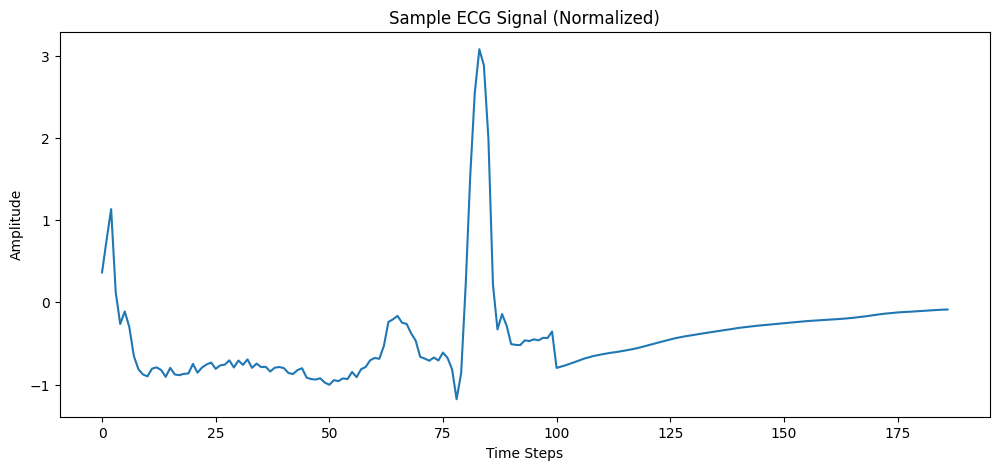

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(X_train_final[0])
plt.title("Sample ECG Signal (Normalized)")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.show()

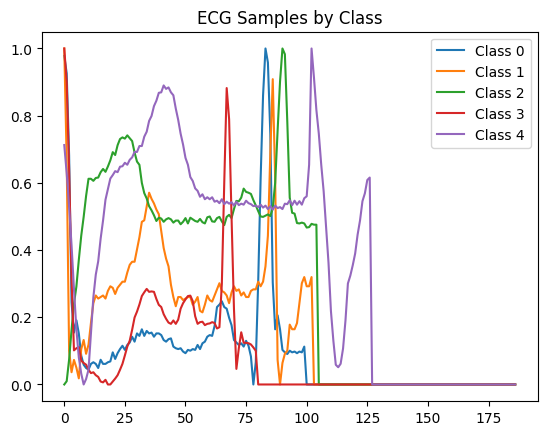

In [ ]:
for c in range(5):
    sample = train[train[187]==c].iloc[0,:187].values
    plt.plot(sample, label=f"Class {c}")

plt.legend()
plt.title("ECG Samples by Class")
plt.show()

# **Model Architecture and Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Bidirectional,
    Conv1D, MaxPooling1D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

model = Sequential([

    # BiLSTM Block 1
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    # BiLSTM Block 2
    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),

    # Classification Head
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True,verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-7,verbose=1)

In [ ]:
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=100,
    batch_size=512,
    validation_data=(X_test_final, y_test_final),
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.4892 - loss: 3.7429 - val_accuracy: 0.1398 - val_loss: 2.8103 - learning_rate: 0.0010
Epoch 2/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.5956 - loss: 1.3637 - val_accuracy: 0.1696 - val_loss: 2.5326 - learning_rate: 0.0010
Epoch 3/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.6233 - loss: 0.9810 - val_accuracy: 0.2014 - val_loss: 2.3262 - learning_rate: 0.0010
Epoch 4/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.6712 - loss: 0.7331 - val_accuracy: 0.3496 - val_loss: 1.9791 - learning_rate: 0.0010
Epoch 5/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.7125 - loss: 0.5914 - val_accuracy: 0.4144 - val_loss: 1.6712 - learning_rate: 0.0010
Epoch 6/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.7466 - loss: 0.4920 - val_accuracy: 0.5354 - val_loss: 1.3231 - learning_rate: 0.0010
Epoch 7/100
415/415 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.7

# **Accuracy and Loss Plots**

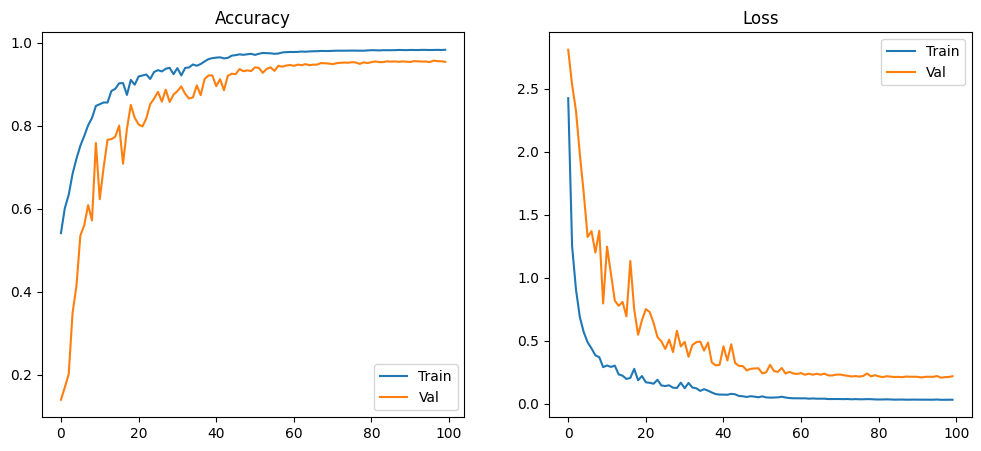

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

# **Calculating Accuracy on Test Set**

In [ ]:
pred = model.predict(X_test_final)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test_final, axis=1)

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)

685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
Test Accuracy: 0.9571076192216335


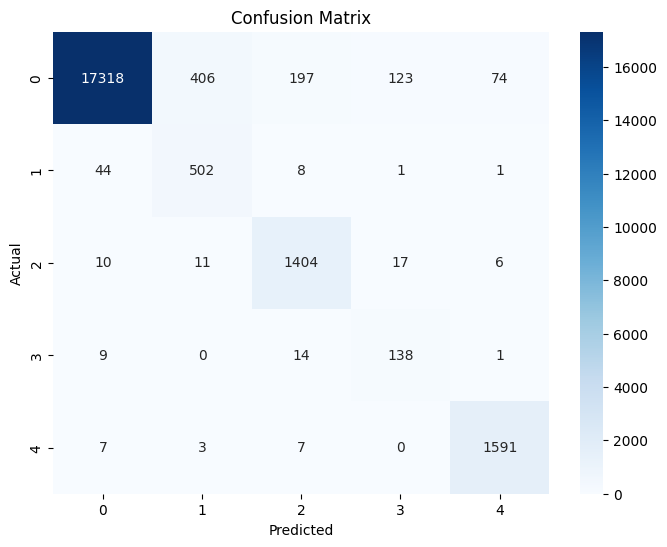

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()